# Prepare Data
Use the 25 really long sequences of IQ data to form a training set for deep learning. The sequences are chopped up into little bits of fixed length (1024 samples unless someone changed it) and arranged into an array. All of the sequences are shuffled and none of the sequences are all zero. The IQ data is converted into a magnitude and phase, so each sample has two channels. (I made a guess that magnitude and phase are easier for a network to interpret than I and Q). Eventually this should take more steps to augment the data.

In [49]:
# TODO turn this into a .py file so that the client can run it

In [50]:
from midas_tools import MidasFile
from numpy.fft import fft
import numpy as np
import os
import random
import matplotlib.pyplot as plt

In [51]:
N_data = 2500  # Number of training data in final augmented dataset
L = 1024      # Length of IQ sequence in each sample
D = 100 # Decimation factor for long-term data
SNRdBmin = 0
SNRdBmax = 20


In [52]:
# Find all of the available data files
data_folder_path = "../../SynthRad21/data/iq/" # This needs to point to where the iq data is on your machine. The data is not in the repo because it is way too big.
data_list = os.listdir(data_folder_path)

In [53]:
data_list = sorted(data_list)
# index refers to the emitter, element is modulation type of the emitter
mod_type = [1,0,0,0,0,0,0,0,0,1,0,1,0,2,0,0,0,0,2,1,0,0,1,0,0] # 0 is UNMOD, 1 is LFM, 2 is BARKER

In [54]:
# Augment the data by picking a random intervals of 1024 samples
data = np.zeros((N_data, L, 8))
labels = np.zeros((N_data, 3)) # 5 columns: 0 is emitter ID, 1 is SNRdB, 2 is modulation 

for i in range(N_data):
    # Pick an emitter, any emitter
    # k = random.randrange(0, np.size(data_list), 1) # Using the full list of emitters
    k = random.randrange(0, np.size(data_list)//2, 1) # Use only the first half of the list of emitters
    # k = random.randrange(np.size(data_list)//2, np.size(data_list), 1) # Use only the second half of the list of emitters
    data_file = data_list[k]
    mf = MidasFile(data_folder_path+data_file)

    fs = mf.sample_rate
    not_done = True
    try_count = 0
    while (not_done and (try_count < 500)):
        # Keep picking random parts of this signal until we get one with some signal in it
        t  = (L+0.000000000001)/fs
        t0 = random.random()*(mf.data_duration-t*D) # Its very possible that an off-by-one error here could cause the file read to crash, but the chances are one in a million even if it is possible

        x = mf.read_at_time(t0, t, reset_time=True)
        x_m = abs(x)
        check_sig = np.sum(x_m)
        if (check_sig > 0):
            not_done = False
        try_count += 1
    
    x_long = mf.read_at_time(t0, t*D, reset_time=True)

    # Augmentation (fuzz the data up to make the network work harder)
    # TODO Add a random shift to the center frequency. Maybe add center frequency as a feature? will need to switch to non-sequential model.
    # Add a random phase offset
    phase = random.uniform(-np.pi, np.pi)
    x_long = x_long * np.exp(1j*phase)

    # Add AWGN noise with random power
    SNRdB = random.uniform(SNRdBmin, SNRdBmax)
    SNR = 10**(SNRdB/10)
    sig_pwr = np.mean(np.abs(x_long)**2)
    sigma2 = sig_pwr/SNR
    noise = np.random.randn(np.size(x_long))*np.sqrt(sigma2/2) + 1j*np.random.randn(np.size(x_long))*np.sqrt(sigma2/2)
    x_long = x_long + noise

    # Generate all of the features that the model will have available to train on
    x_short = x_long[np.arange(0, int(np.size(x_long)/D), 1)]
    x_long = x_long[np.arange(0, np.size(x_long), D)]
    xf_short = fft(x_short)
    xf_long = fft(x_long)
    x_ms = abs(x_short)
    x_ps = np.angle(x_short)
    x_ml = abs(x_long)
    x_pl = np.angle(x_long)
    xf_ms = abs(xf_short)
    xf_ps = np.angle(xf_short)
    xf_ml = abs(xf_long)
    xf_pl = np.angle(xf_long)

    data[i,:,0] = x_ms
    data[i,:,1] = x_ps
    data[i,:,2] = x_ml
    data[i,:,3] = x_pl
    data[i,:,4] = xf_ms
    data[i,:,5] = xf_ps
    data[i,:,6] = xf_ml
    data[i,:,7] = xf_pl
    labels[i,0] = k
    labels[i,1] = SNRdB
    labels[i,2] = mod_type[k]

In [55]:
label_names =  ['angry_alpaca_sas.tmp',
                'angry_bear_sas.tmp',
                'angry_bobcat_sas.tmp',
                'angry_camel_sas.tmp',
                'angry_cheetah_sas.tmp',
                'angry_deer_sas.tmp',
                'angry_dingo_a.tmp',
                'angry_goat_sas.tmp',
                'angry_gorilla_t.tmp',
                'angry_hare_sas.tmp',
                'angry_jackal_a.tmp',
                'angry_jaguar_sas.tmp',
                'angry_kangaroo_a.tmp',
                'angry_lion_t.tmp',
                'angry_mandrill_t.tmp',
                'angry_marmot_t.tmp',
                'angry_mink_sas.tmp',
                'angry_mole_t.tmp',
                'angry_mouse_t.tmp',
                'angry_puma_sas.tmp',
                'angry_rat_t.tmp',
                'angry_starling_ti.tmp',
                'angry_weasel_sas.tmp',
                'angry_wolf_sas.tmp',
                'angry_zebra_sas.tmp']


Emitter: angry_dingo_a.tmp SNR 12.344105734195667 UNMOD 0.0


<function matplotlib.pyplot.show(close=None, block=None)>

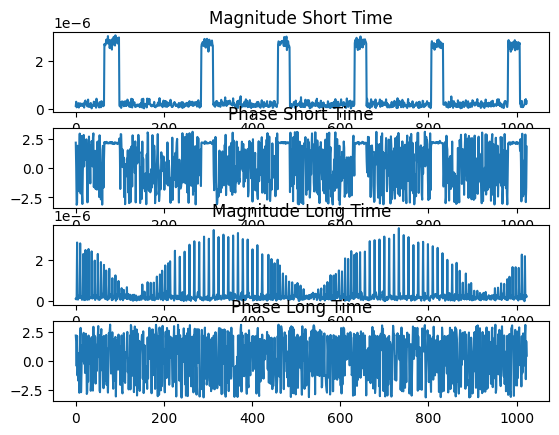

In [56]:
index = 0

print('Emitter:', label_names[int(labels[index,0])], 'SNR', labels[index,1], 'UNMOD', labels[index,2])
ax1 = plt.subplot(411)
plt.plot(data[index,:,0])
plt.title('Magnitude Short Time')
ax2 = plt.subplot(412,sharex=ax1)
plt.plot(data[index,:,1])
plt.title('Phase Short Time')
ax1 = plt.subplot(413)
plt.plot(data[index,:,2])
plt.title('Magnitude Long Time')
ax2 = plt.subplot(414,sharex=ax1)
plt.plot(data[index,:,3])
plt.title('Phase Long Time')
plt.show


<function matplotlib.pyplot.show(close=None, block=None)>

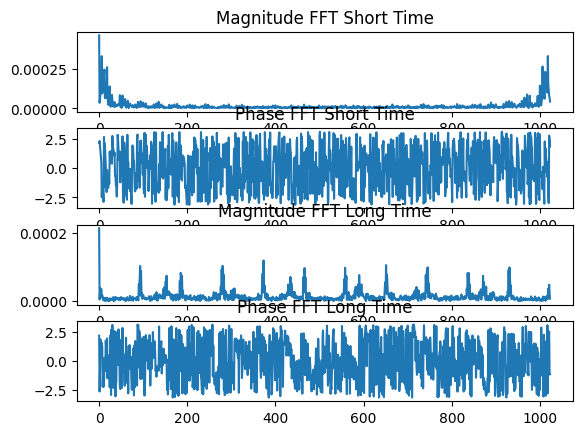

In [57]:
ax1 = plt.subplot(411)
plt.plot(data[index,:,4])
plt.title('Magnitude FFT Short Time')
ax2 = plt.subplot(412,sharex=ax1)
plt.plot(data[index,:,5])
plt.title('Phase FFT Short Time')
ax1 = plt.subplot(413)
plt.plot(data[index,:,6])
plt.title('Magnitude FFT Long Time')
ax2 = plt.subplot(414,sharex=ax1)
plt.plot(data[index,:,7])
plt.title('Phase FFT Long Time')
plt.show

In [58]:
# Save the prepared training data
data_out_name = 'data04_test_2500'
labels_out_name = 'labels04_test_2500'
# data_out_name = 'trash'
# labels_out_name = 'trash'
out_file_dir  = 'training_data/'

np.save(out_file_dir+data_out_name, data)
np.save(out_file_dir+labels_out_name, labels)